## Import Library

In [110]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

## Data Exploration & Data Understanding

In [111]:
df = pd.read_csv('data_penjualan.csv', delimiter=";")

print("Jumlah data (baris, kolom):", df.shape)
print("\nInformasi tipe data dan skema pengkodean:")
print(df.info())
print("\nStatistik deskriptif untuk data numerik:")
print(df.describe())
print("\nBeberapa baris pertama data:")
print(df.head())

df.shape

Jumlah data (baris, kolom): (1076, 5)

Informasi tipe data dan skema pengkodean:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1076 entries, 0 to 1075
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Tanggal       1076 non-null   object
 1   Jenis Produk  1076 non-null   object
 2   Jumlah Order  1076 non-null   int64 
 3   Harga         1076 non-null   int64 
 4   Total         1076 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 42.2+ KB
None

Statistik deskriptif untuk data numerik:
       Jumlah Order         Harga         Total
count   1076.000000   1076.000000  1.076000e+03
mean    1904.933086   1703.781599  2.345827e+06
std     2500.918899   3355.881482  1.730798e+06
min        5.000000    100.000000  1.537600e+04
25%     1000.000000    950.000000  1.312500e+06
50%     1000.000000   1500.000000  1.800000e+06
75%     2000.000000   1850.000000  3.000000e+06
max    40000.000000  99970.000000  2.

(1076, 5)

## Data Cleaning

In [112]:
# Cek missing value
missing = df.isnull().sum()
print(missing)

# Bisa juga lihat persentase
missing_percent = (df.isnull().mean() * 100).round(2)
print(missing_percent)

# Deteksi Outlier dengan IQR 
def detect_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return series[(series < lower) | (series > upper)]

outliers_jumlah = detect_outliers_iqr(df["Jumlah Order"])
outliers_harga = detect_outliers_iqr(df["Harga"])
outliers_total = detect_outliers_iqr(df["Total"])

print("Outlier Jumlah Order:", len(outliers_jumlah))
print("Outlier Harga:", len(outliers_harga))
print("Outlier Total:", len(outliers_total))

Tanggal         0
Jenis Produk    0
Jumlah Order    0
Harga           0
Total           0
dtype: int64
Tanggal         0.0
Jenis Produk    0.0
Jumlah Order    0.0
Harga           0.0
Total           0.0
dtype: float64
Outlier Jumlah Order: 95
Outlier Harga: 33
Outlier Total: 69


Tidak ditemukan missing Values. Outlier yang terdeteksi pada kolom Jumlah Order (95 entri), Harga (33 entri), dan Total (69 entri) tidak dihapus karena berpotensi merepresentasikan kasus nyata, seperti pembelian dalam jumlah besar, harga promo khusus, atau diskon ekstrem. Menghapus outlier justru berisiko menghilangkan informasi penting yang relevan dengan analisis bisnis. Oleh karena itu, outlier tetap dipertahankan dan akan diperhatikan secara khusus dalam tahap analisis selanjutnya.

## Koreksi Data Kotor

In [113]:
# Membersihkan nama kolom
df.columns = [c.strip() for c in df.columns]

# Konversi numerik
df["Jumlah Order"] = pd.to_numeric(df["Jumlah Order"], errors="coerce")
df["Harga"] = pd.to_numeric(df["Harga"], errors="coerce")
df["Total"] = pd.to_numeric(df["Total"], errors="coerce")

# Hitung ulang Total untuk memastikan
df["Total_Recalc"] = df["Jumlah Order"] * df["Harga"]

# Cari baris yang salah
wrong_rows = df[df["Total"] != df["Total_Recalc"]]

print(f"Jumlah data salah: {len(wrong_rows)}")
print(wrong_rows.head())

Jumlah data salah: 0
Empty DataFrame
Columns: [Tanggal, Jenis Produk, Jumlah Order, Harga, Total, Total_Recalc]
Index: []


## Transformasi Data

In [114]:
# Pastikan tipe
df["Tanggal"] = pd.to_datetime(df["Tanggal"], errors="coerce")
df["Jumlah Order"] = pd.to_numeric(df["Jumlah Order"], errors="coerce")
df["Harga"] = pd.to_numeric(df["Harga"], errors="coerce")
df["Total"] = pd.to_numeric(df["Total"], errors="coerce")

# Rekayasa fitur dari tanggal 
df["Tahun"] = df["Tanggal"].dt.year.astype("Int64")   # nullable int
df["Bulan"] = df["Tanggal"].dt.month.astype("Int64")  # nullable int
df["Hari"] = df["Tanggal"].dt.day.astype("Int64")     # nullable int
df["HariMinggu"] = df["Tanggal"].dt.day_name()

# Bikin kolom Periode (YYYY-MM) siap pakai
df["Periode"] = pd.to_datetime(
    df["Tahun"].astype(str) + "-" + df["Bulan"].astype(str).str.zfill(2),
    errors="coerce"
)

df.head()


,Tanggal,Jenis Produk,Jumlah Order,Harga,Total,Total_Recalc,Tahun,Bulan,Hari,HariMinggu,Periode
0,2022-05-08,Foodpak260,1000,1800,1800000,1800000,2022,5,8,Sunday,2022-05-01
1,2022-05-08,FoodpakMatte245,1000,1900,1900000,1900000,2022,5,8,Sunday,2022-05-01
2,2022-05-08,CraftLaminasi290,5000,750,3750000,3750000,2022,5,8,Sunday,2022-05-01
3,2022-05-08,CraftLaminasi290,1000,1200,1200000,1200000,2022,5,8,Sunday,2022-05-01
4,2022-07-08,Dupleks310,1000,1550,1550000,1550000,2022,7,8,Friday,2022-07-01


## Data Labeling

In [115]:
bins = [0, 3_300_000, 5_600_000, float('inf')]
labels = ['Rendah', 'Sedang', 'Tinggi']

df['Kategori_Total_Asli'] = pd.cut(df['Total'], bins=bins, labels=labels)
print(df.head())

# Hitung distribusi persentase
distribusi_asli = df['Kategori_Total_Asli'].value_counts(normalize=True) * 100
print(distribusi_asli)

     Tanggal      Jenis Produk  Jumlah Order  Harga    Total  Total_Recalc  \
0 2022-05-08        Foodpak260          1000   1800  1800000       1800000   
1 2022-05-08   FoodpakMatte245          1000   1900  1900000       1900000   
2 2022-05-08  CraftLaminasi290          5000    750  3750000       3750000   
3 2022-05-08  CraftLaminasi290          1000   1200  1200000       1200000   
4 2022-07-08        Dupleks310          1000   1550  1550000       1550000   

   Tahun  Bulan  Hari HariMinggu    Periode Kategori_Total_Asli  
0   2022      5     8     Sunday 2022-05-01              Rendah  
1   2022      5     8     Sunday 2022-05-01              Rendah  
2   2022      5     8     Sunday 2022-05-01              Sedang  
3   2022      5     8     Sunday 2022-05-01              Rendah  
4   2022      7     8     Friday 2022-07-01              Rendah  
Kategori_Total_Asli
Rendah    80.111524
Sedang    13.661710
Tinggi     6.226766
Name: proportion, dtype: float64


## Visualisasi Data

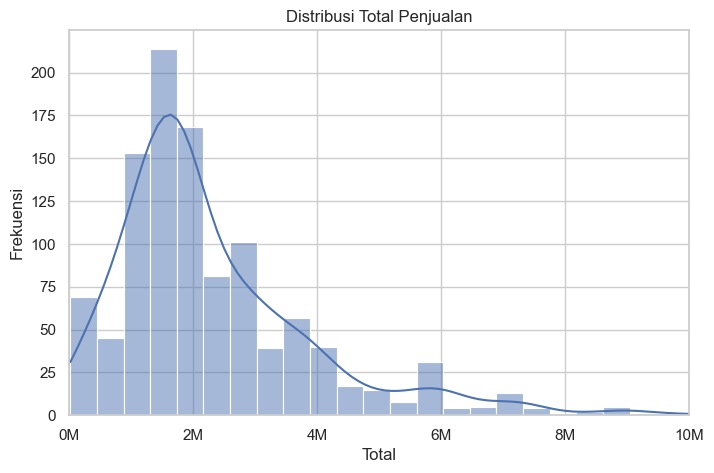

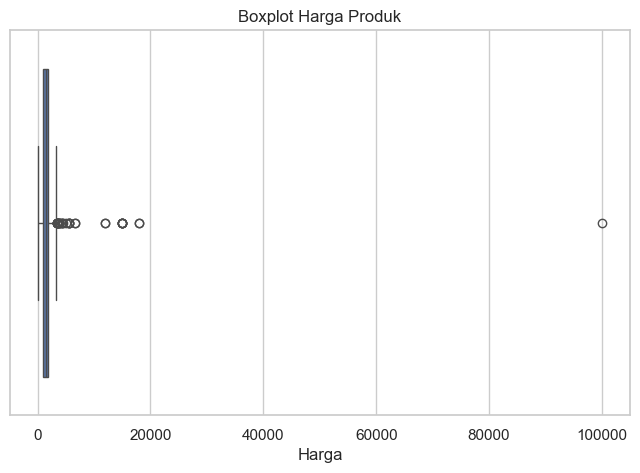

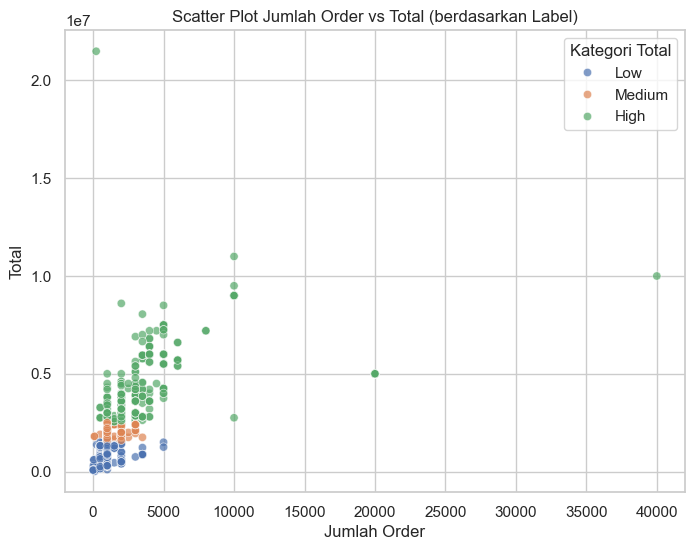

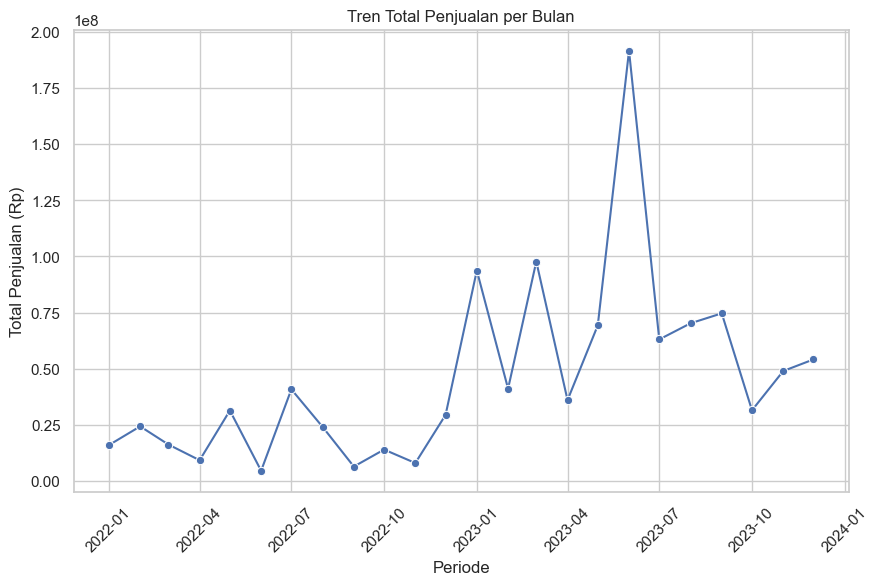

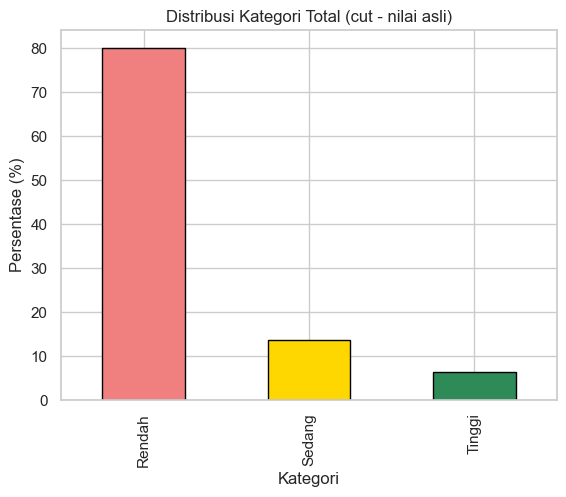

In [116]:
# Histogram distribusi Total
plt.figure(figsize=(8,5))
sns.histplot(df["Total"], bins=50, kde=True)
plt.title("Distribusi Total Penjualan")
plt.xlabel("Total")
plt.ylabel("Frekuensi")
plt.xlim(0, 10_000_000)
plt.gca().xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f'{int(x/1_000_000)}M')
)
plt.show()

# Boxplot Harga
plt.figure(figsize=(8,5))
sns.boxplot(x=df["Harga"])
plt.title("Boxplot Harga Produk")
plt.xlabel("Harga")
plt.show()

# Bikin label dulu (contoh kategorisasi berdasarkan quantile)
df["Label_Total"] = pd.qcut(df["Total"], q=3, labels=["Low", "Medium", "High"])

# Scatter plot Jumlah Order vs Total dengan label
plt.figure(figsize=(8,6))
sns.scatterplot(x="Jumlah Order", y="Total", hue="Label_Total", data=df, alpha=0.7)
plt.title("Scatter Plot Jumlah Order vs Total (berdasarkan Label)")
plt.xlabel("Jumlah Order")
plt.ylabel("Total")
plt.legend(title="Kategori Total")
plt.show()

# Agregasi total penjualan per bulan
df_tren = df.groupby(["Tahun", "Bulan"])["Total"].sum().reset_index()

# Biar gampang dibaca, bikin kolom periode (YYYY-MM)
df_tren["Periode"] = pd.to_datetime(df_tren["Tahun"].astype(str) + "-" + df_tren["Bulan"].astype(str))

# Plot line chart tren penjualan
plt.figure(figsize=(10,6))
sns.lineplot(x="Periode", y="Total", data=df_tren, marker="o")
plt.title("Tren Total Penjualan per Bulan")
plt.xlabel("Periode")
plt.ylabel("Total Penjualan (Rp)")
plt.xticks(rotation=45)
plt.show()

# Visualisasi distribusi label dari cut (pakai nilai asli/bins)
df['Kategori_Total_Asli'].value_counts(normalize=True).mul(100).plot(
    kind='bar',
    color=['lightcoral', 'gold', 'seagreen'],
    edgecolor='black'
)
plt.title("Distribusi Kategori Total (cut - nilai asli)")
plt.ylabel("Persentase (%)")
plt.xlabel("Kategori")
plt.show()